## Content

1. [User IBM cloud API](#User-IBM-cloud-API)
2. [Initiate session](#Initiate-session)
3. [Methods](#Methods)
4. [QUBO coefficients](#QUBO-coefficients)
4. [QUBO Hamiltonian](#QUBO-Hamiltonian)
5. [QAOA ansatz](#QAOA-ansatz)
6. [Parameterized Quantum Circuit](#Parameterized-Quantum-Circuit)
7. [Cost function](#Cost-function)
8. [Optimization](#Optimization)
9. [Results](#Results)

### User IBM cloud API

In [1]:
token_api = ''

### Initiate session

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_quantum", token=token_api)

### Methods

In [3]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import Estimator, Sampler, Session
from scipy.optimize import minimize
from qiskit import transpile, execute

###  QUBO coefficients

In [4]:
qubits = [sp.Symbol("q1"), sp.Symbol("q2"), sp.Symbol("q3")]

p1, p2, p3 = 39.5, 3.6, 87.8
N = 100
asset_prices = [p1, p2, p3]
function = -N + p1 * qubits[0] + p2 * qubits[1] +  p3 * qubits[2]
    
square_function = function**2

In [5]:
qubo = square_function.expand()
qubo

1560.25*q1**2 + 284.4*q1*q2 + 6936.2*q1*q3 - 7900.0*q1 + 12.96*q2**2 + 632.16*q2*q3 - 720.0*q2 + 7708.84*q3**2 - 17560.0*q3 + 10000

In [6]:
def qubo_matrix(init_coeffs, cost_fun):
    
    nb_qb = len(init_coeffs)
    matrix = np.zeros((nb_qb, nb_qb))
    
    for i in range(nb_qb):
        
        matrix[i,i] = cost_fun.coeff(f"q{i + 1}**2") + cost_fun.coeff(f"q{i + 1}").args[0]
        
        for j in range(i + 1, nb_qb):
            
            matrix[i,j] = cost_fun.coeff(f"q{i + 1}*q{j + 1}")
            matrix[j,i] = cost_fun.coeff(f"q{i + 1}*q{j + 1}")
            
    return matrix

In [7]:
coeffs = qubo_matrix(asset_prices, qubo)
sp.Matrix(np.triu(coeffs))

Matrix([
[-6339.75,   284.4,   6936.2],
[       0, -707.04,   632.16],
[       0,       0, -9851.16]])

In [8]:
def gate_qubo_matrix(qubo_coeffs, qubo):
    
    nb_qb = len(qubo_coeffs)
    gate_coeffs = np.zeros((nb_qb, nb_qb))
    
    constant =  qubo.args[0]
    for i in range(nb_qb):
        
        constant += 0.5 * qubo_coeffs[i,i]
        
        gate_coeffs[i,i] = -0.5 * sum(qubo_coeffs[i])
        
        for j in range(i + 1, nb_qb):
            constant += 0.25 * qubo_coeffs[i,j]
            gate_coeffs[i,j] = qubo_coeffs[i,j] / 4
    
    return [gate_coeffs, constant]

In [9]:
gate_qubo = gate_qubo_matrix(coeffs, qubo)
sp.Matrix(gate_qubo[0])

Matrix([
[-440.425,    71.1, 1734.05],
[       0, -104.76,  158.04],
[       0,       0,  1141.4]])

###  QUBO Hamiltonian

In [10]:
def pauli_z_hamiltonian(coefficients):
    
    h = []
    nb_qubits = len(coefficients)
    
    for i in range(nb_qubits):
        h.append(('Z', [i], coefficients[i, i]))
        
    for i in range(nb_qubits):
        for j in range(i + 1, nb_qubits):
            h.append(("ZZ", [i,j], coefficients[i, j]))
    
    hamiltonian = SparsePauliOp.from_sparse_list(h, num_qubits = nb_qubits)
    
    return hamiltonian

In [11]:
hamiltonian = pauli_z_hamiltonian(gate_qubo[0])
hamiltonian

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[-440.425+0.j, -104.76 +0.j, 1141.4  +0.j,   71.1  +0.j, 1734.05 +0.j,
  158.04 +0.j])

### QAOA ansatz

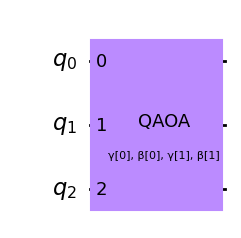

In [12]:
ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.draw("mpl")

### Parameterized Quantum Circuit

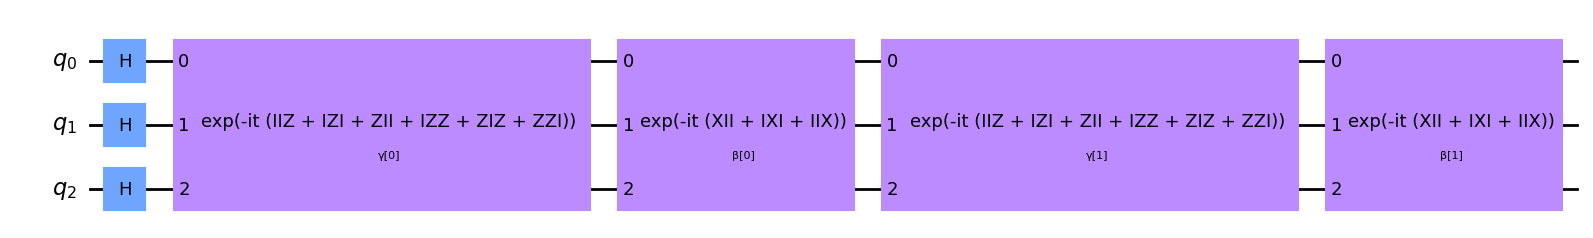

In [13]:
# Decompose
ansatz.decompose(reps=1).draw("mpl")

### Cost function

In [14]:
backend = service.backend("ibmq_qasm_simulator")

In [15]:
session = Session(backend=backend)
estimator = Estimator(session=session, options={"shots": 1000})

In [16]:
def cost_func(params, ansatz, hamiltonian, estimator):

    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    
    return cost

### Optimization

Initial guess

In [17]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters) 

Minimize cost function using Finite Differences method (gradient approximation)

In [590]:
#res_fd = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="trust-constr")

In [17]:
res_fd_x = [4.473e+00,  4.256e+00,  4.425e+00,  4.059e+00]

Minimize cost function using COBYLA method (gradient free)

In [592]:
#res_ng = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="cobyla")

In [18]:
res_ng_x = [4.928e+00,  3.866e+00,  4.692e+00,  3.549e+00]

### Results

Quantum simulator

In [19]:
for s in service.backends():
    if 'simulator' in s.name:
        print(s.name)

simulator_extended_stabilizer
simulator_mps
simulator_statevector
simulator_stabilizer
ibmq_qasm_simulator


In [35]:
sampler = Sampler(session='ibmq_qasm_simulator', options={"shots": 1000})

In [36]:
qaoa_fd = ansatz.assign_parameters(res_fd_x)
qaoa_fd.measure_all()
transpiled_qaoa_fd = transpile(qaoa_fd, backend)
res_qaoa_fd_qs = sampler.run(transpiled_qaoa_fd).result().quasi_dists[0]

{'101': 0.053, '111': 0.003, '011': 0.098, '000': 0.377, '010': 0.021, '001': 0.171, '110': 0.228, '100': 0.049}


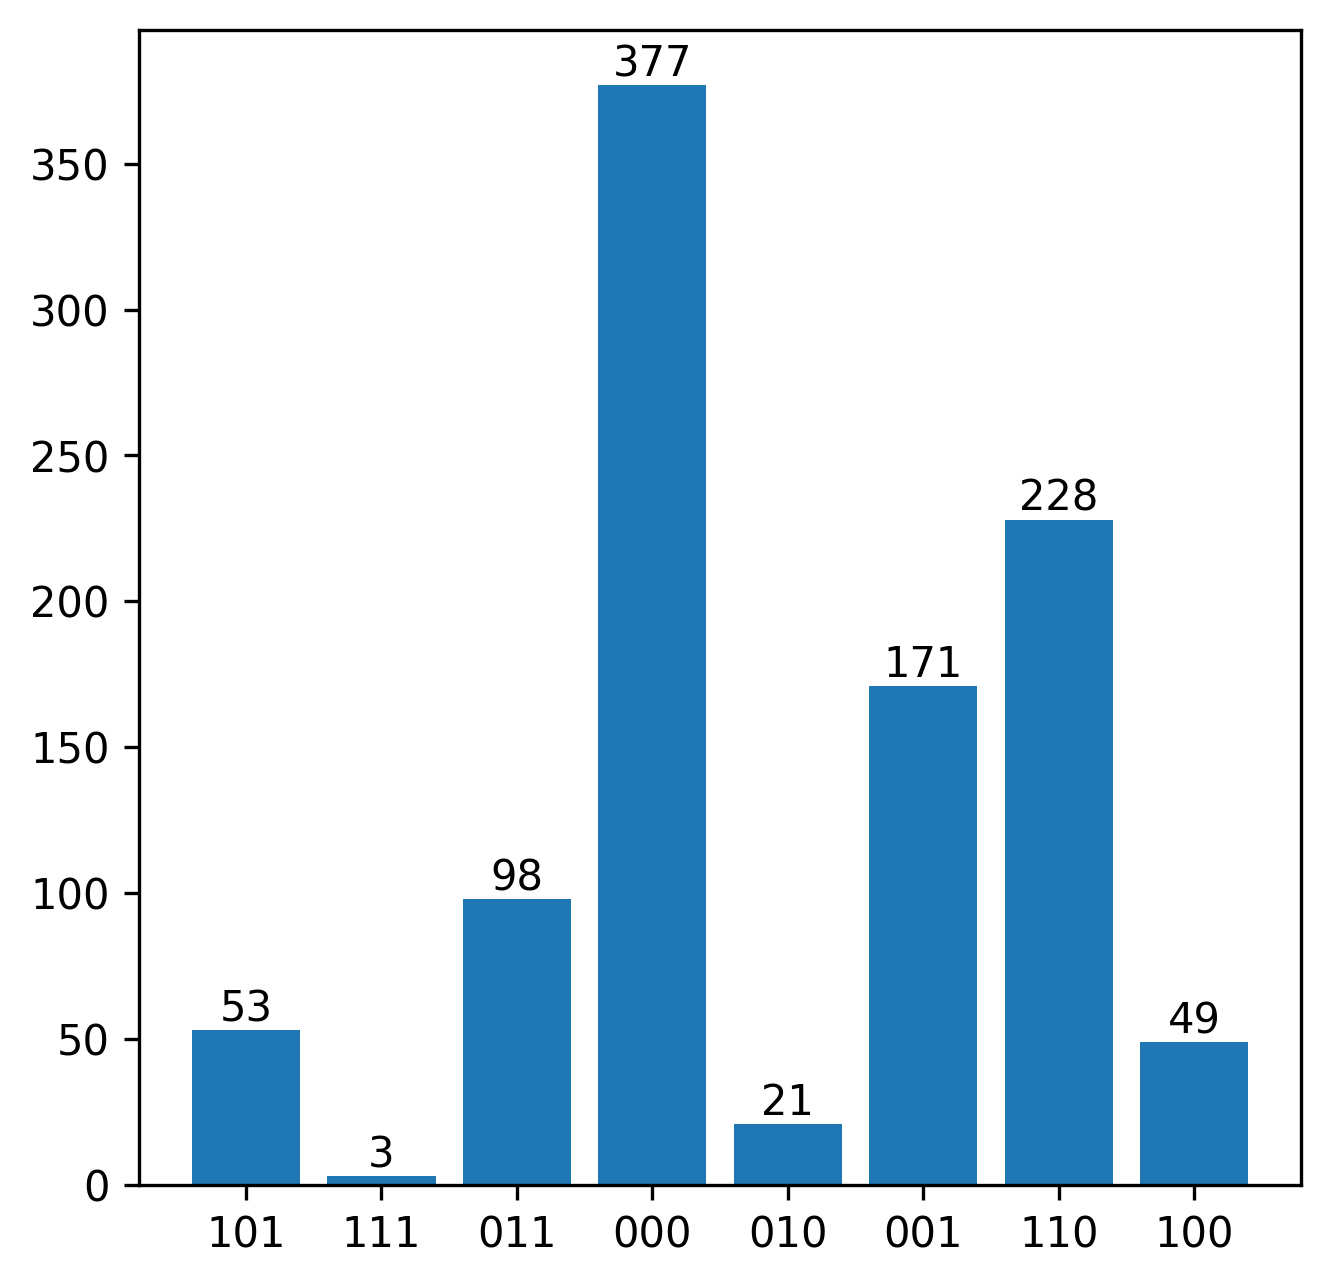

In [37]:
res_dict_3_fd = res_qaoa_fd_qs.binary_probabilities()
print(res_dict_3_fd)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_3_fd.values()]
counts = plt.bar(range(len(res_dict_3_fd)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_fd)), list(res_dict_3_fd.keys()))
plt.show()

In [39]:
qaoa_ng = ansatz.assign_parameters(res_ng_x)
qaoa_ng.measure_all()
transpiled_qaoa_ng = transpile(qaoa_ng, backend)
res_qaoa_ng_qs = sampler.run(transpiled_qaoa_ng).result().quasi_dists[0]

{'101': 0.023, '001': 0.448, '010': 0.015, '100': 0.329, '110': 0.1, '000': 0.003, '111': 0.067, '011': 0.015}


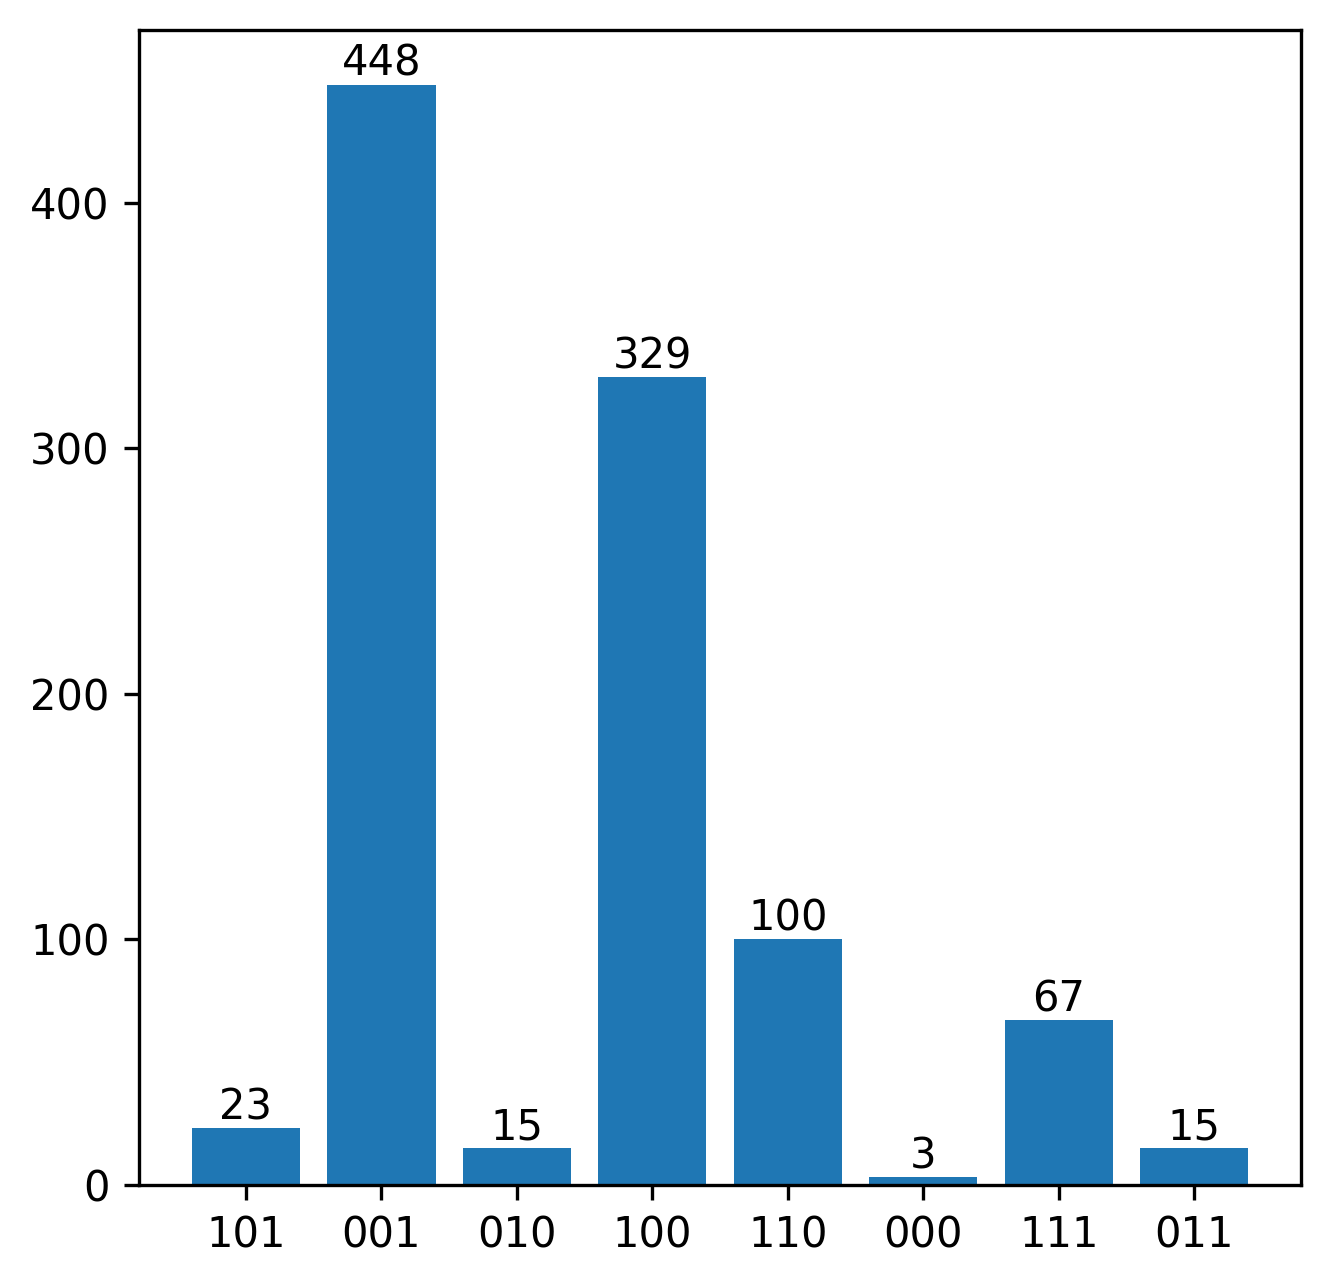

In [40]:
res_dict_3_ng = res_qaoa_ng_qs.binary_probabilities()
print(res_dict_3_ng)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_3_ng.values()]
counts = plt.bar(range(len(res_dict_3_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_ng)), list(res_dict_3_ng.keys()))
plt.show()

### Other

{'010': 0.048, '110': 0.21, '100': 0.204, '000': 0.042, '111': 0.008, '011': 0.256, '101': 0.158, '001': 0.074}


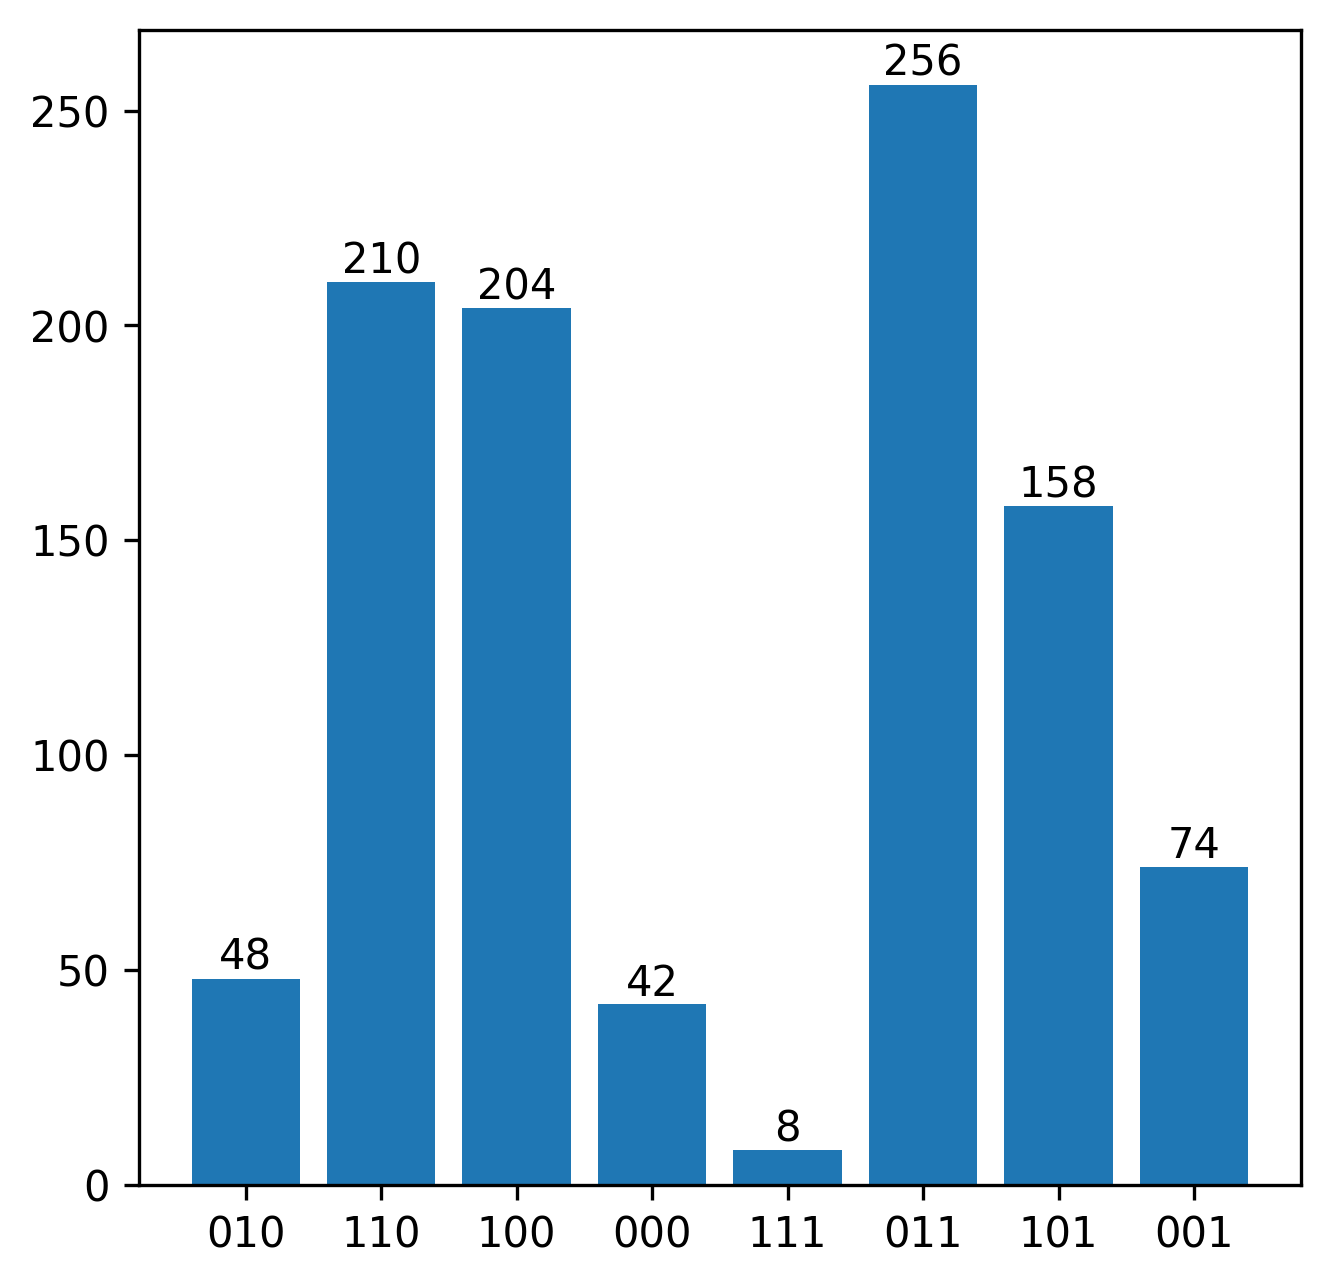

In [41]:
res_fd_x = [1.992e+00, 2.008e+00, 3.429e+00, 5.053e+00]
qaoa_fd = ansatz.assign_parameters(res_fd_x)
qaoa_fd.measure_all()
transpiled_qaoa_fd = transpile(qaoa_fd, backend)
res_qaoa_fd_qs = sampler.run(transpiled_qaoa_fd).result().quasi_dists[0]
res_dict_3_fd = res_qaoa_fd_qs.binary_probabilities()
print(res_dict_3_fd)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_3_fd.values()]
counts = plt.bar(range(len(res_dict_3_fd)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_fd)), list(res_dict_3_fd.keys()))
plt.show()

{'010': 0.021, '001': 0.065, '111': 0.102, '011': 0.175, '000': 0.079, '101': 0.137, '110': 0.134, '100': 0.287}


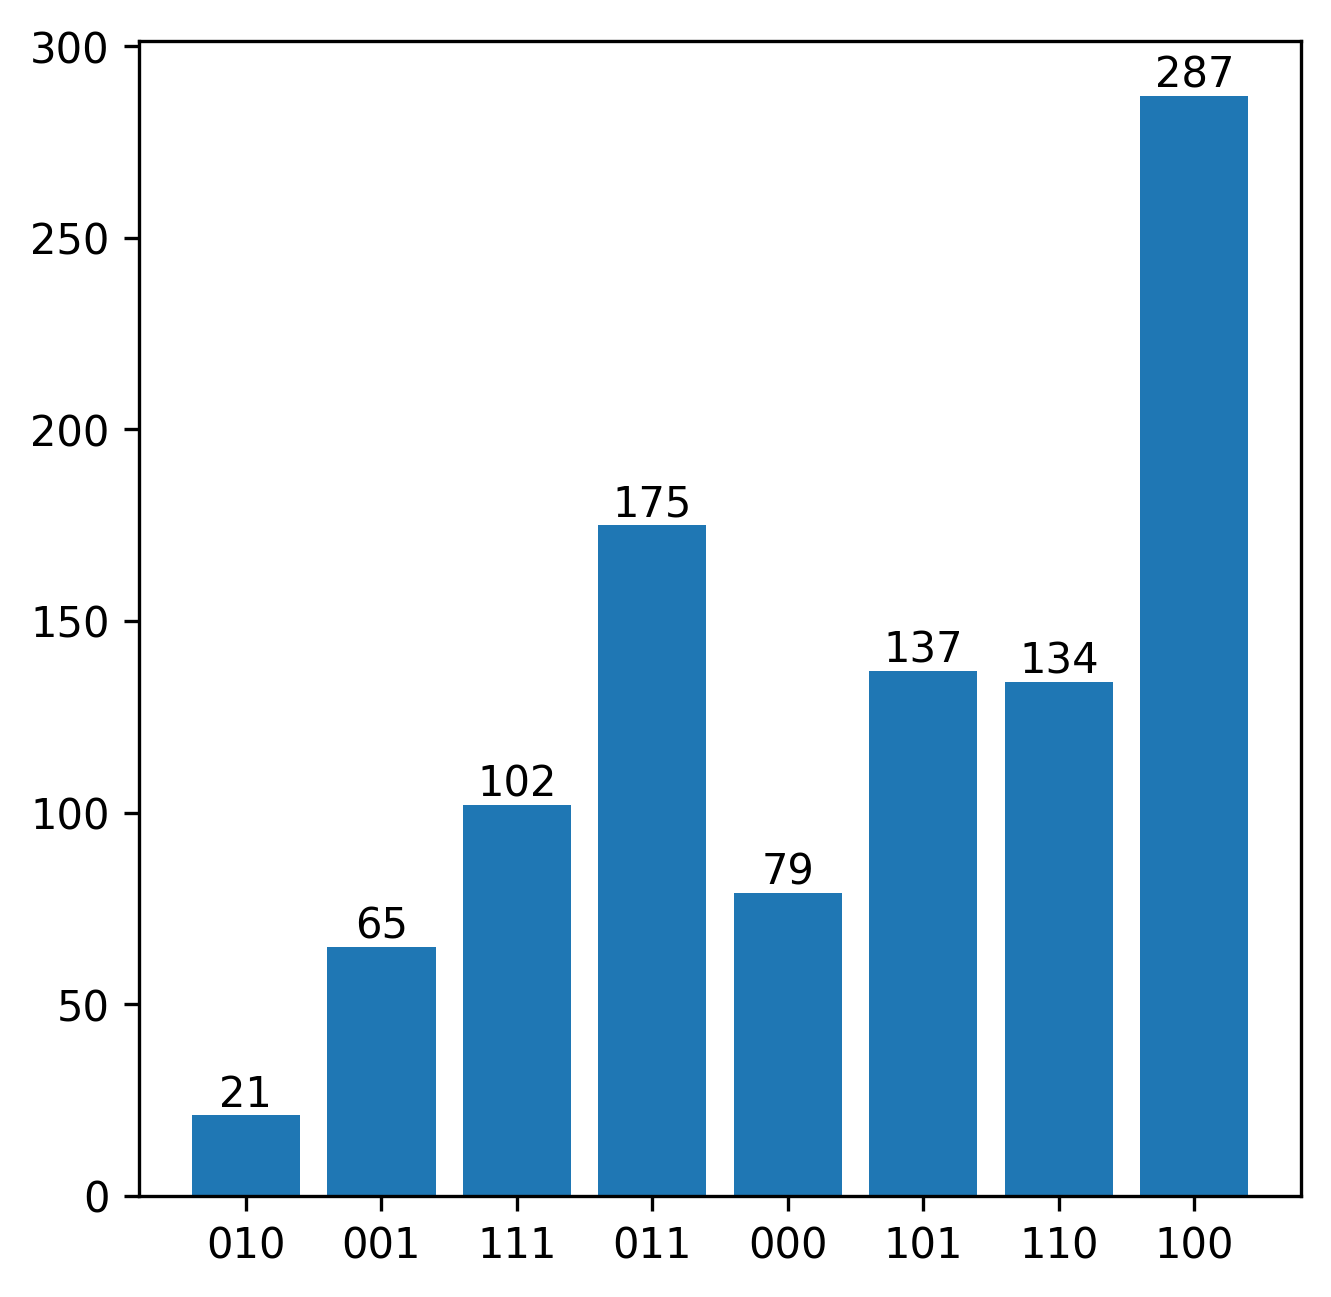

In [42]:
res_ng_x = [2.155e+00, 3.134e+00, 3.456e+00, 6.388e+00]
qaoa_ng = ansatz.assign_parameters(res_ng_x)
qaoa_ng.measure_all()
transpiled_qaoa_ng = transpile(qaoa_ng, backend)
res_qaoa_ng_qs = sampler.run(transpiled_qaoa_ng).result().quasi_dists[0]
res_dict_3_ng = res_qaoa_ng_qs.binary_probabilities()
print(res_dict_3_ng)
plt.figure(figsize=(5,5), dpi=300)
round_values = [round(1000 * i) for i in res_dict_3_ng.values()]
counts = plt.bar(range(len(res_dict_3_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_ng)), list(res_dict_3_ng.keys()))
plt.show()